In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set()

In [2]:
import itertools

import statsmodels.api as sm

from sklearn.metrics import mean_squared_error

from math import sqrt

In [3]:
from statsmodels.tsa.arima_model import ARIMA

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
water = pd.read_csv('water.csv', header=0, index_col=0, parse_dates=True)

In [6]:
water

,Water
Year,
1885-01-01,356
1886-01-01,386
1887-01-01,397
1888-01-01,397
1889-01-01,413
...,...
1959-01-01,594
1960-01-01,587
1961-01-01,587


### Visualization

<function matplotlib.pyplot.show(close=None, block=None)>

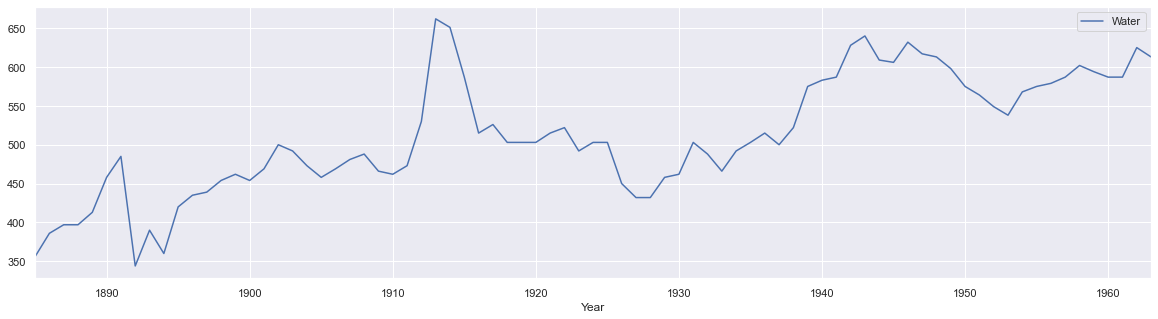

In [9]:
water.plot(figsize=(20,5))
plt.show

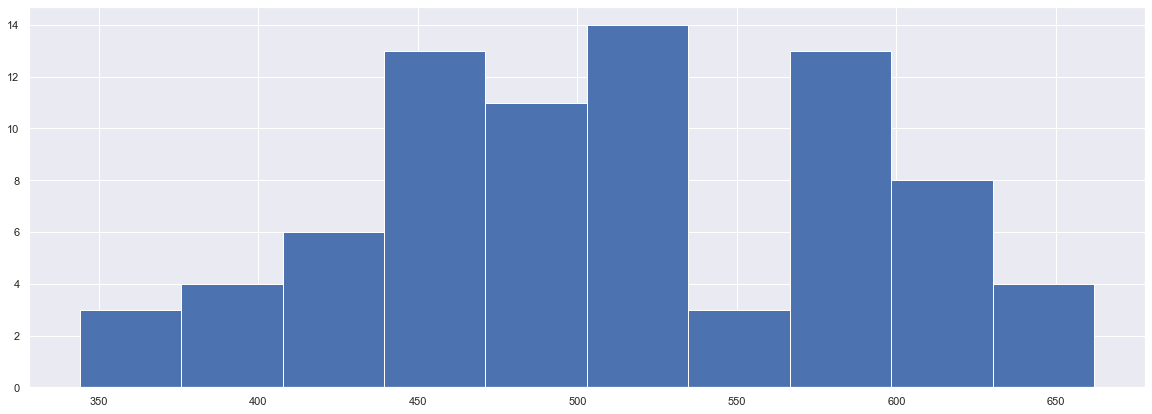

In [11]:
plt.figure(figsize=(20,7))
plt.hist(water['Water'])
plt.show()

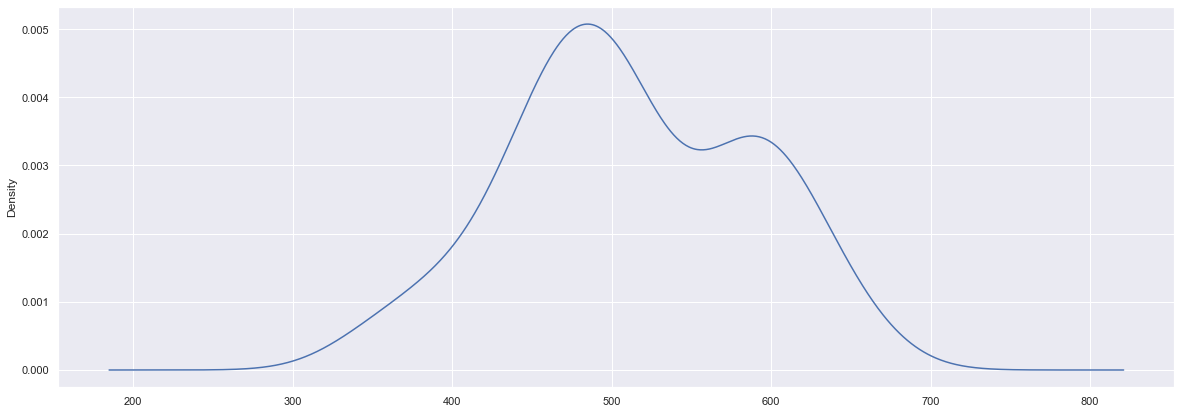

In [12]:
plt.figure(figsize=(20,7))
water['Water'].plot(kind = 'kde')
plt.show()

### Splitting the Data

In [13]:
dataset    = water.head(69)
validation = water.tail(10)

print('Dataset %d, Validation %d' % (len(dataset), len(validation)))
dataset.to_csv('dataset.csv', header=False)
validation.to_csv('validation.csv', header=False)

Dataset 69, Validation 10


In [19]:
dataset['Water'].dtype

dtype('int64')

### Base Model

In [20]:
X = dataset.values

train_size = int(len(X)*0.8)

train,test = X[0:train_size], X[train_size:]


In [25]:
# walk-forward validation -- simple - todays temp is tomorrows temp prediction  

history = [x for x in train]

predictions = []

for i in range(len(test)):
    yhat = history[-1]
    predictions.append(yhat)
    
    # observation
    obs = test[i]
    history.append(obs)     # history list is getting appended - so this will be prediction for next day
    
    print(f'> Predicted = {yhat},  Observed ={obs}')
    

> Predicted = [575],  Observed =[583]
> Predicted = [583],  Observed =[587]
> Predicted = [587],  Observed =[628]
> Predicted = [628],  Observed =[640]
> Predicted = [640],  Observed =[609]
> Predicted = [609],  Observed =[606]
> Predicted = [606],  Observed =[632]
> Predicted = [632],  Observed =[617]
> Predicted = [617],  Observed =[613]
> Predicted = [613],  Observed =[598]
> Predicted = [598],  Observed =[575]
> Predicted = [575],  Observed =[564]
> Predicted = [564],  Observed =[549]
> Predicted = [549],  Observed =[538]


In [30]:
# report performance

rmse = sqrt(mean_squared_error(predictions,test))
print(f'RMSE is {np.round(rmse,3)}')

RMSE is 18.923


### ARIMA MODEL  - Hyper Parameters

In [37]:
# evaluate an ARIMA model for a given order (p,d,q) and return RMSE
def evaluate_arima_model(X, arima_order):
# prepare training dataset
    X = X.astype('float32')
    train_size = int(len(X)*0.8)

    train,test = X[0:train_size], X[train_size:]
    
    history_arima = [x for x in train]
    
# Predictions
    predictions_arima = []
    
    for i in range(len(test)):
        model = ARIMA(endog=history_arima, order= arima_order)   # history is nothing bust list of train data
# Model Fitting
        model_fit = model.fit(disp=0)
        
        yhat = model_fit.forecast()[0]
        
        predictions_arima.append(yhat)
        
        history_arima.append(test[i])           # Local avg updated - history is updated here ofr next model pred

# calculate out of sample error
    rmse_arima = sqrt(mean_squared_error(predictions_arima, test))
    
    return rmse_arima

### Grid search for p,d,q values   === Order  


In [38]:
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(data, p_values, d_values, q_values):
    data = data.astype('float32')
    
    best_score, best_cfg = float('inf'), None
    
    for p in p_values:
        for d in d_values:
            for q in q_values:
                
                order = (p,d,q)
                try:
                    rmse = evaluate_arima_model(train, order)
                    if rmse < best_score:
                        best_score, best_cfg = rmse,order
                        
                    print(f'ARIMA {order} Model has RMSE {np.round(rmse,3)} ')
                    
                except Exception as e:
                    print(e)
                    continue
    print(f'Best ARIMA Model {best_cfg} has RMSE {best_score} ')

In [35]:
X = dataset.values

train_size = int(len(X)*0.8)

train,test = X[0:train_size], X[train_size:]

# evaluate parameters
p_values = range(0, 5)
d_values = range(0, 5)
q_values = range(0, 5)

In [39]:
evaluate_models(train,p_values,d_values,q_values)

ARIMA (0, 0, 0) Model has RMSE 40.533 
ARIMA (0, 0, 1) Model has RMSE 31.589 
ARIMA (0, 0, 2) Model has RMSE 29.619 
ARIMA (0, 0, 3) Model has RMSE 29.826 
ARIMA (0, 0, 4) Model has RMSE 27.552 
ARIMA (0, 1, 0) Model has RMSE 25.094 
ARIMA (0, 1, 1) Model has RMSE 25.162 
ARIMA (0, 1, 2) Model has RMSE 24.235 
ARIMA (0, 1, 3) Model has RMSE 24.355 
ARIMA (0, 1, 4) Model has RMSE 25.063 
ARIMA (0, 2, 0) Model has RMSE 32.414 
ARIMA (0, 2, 1) Model has RMSE 29.04 
ARIMA (0, 2, 2) Model has RMSE 28.915 
ARIMA (0, 2, 3) Model has RMSE 29.987 
ARIMA (0, 2, 4) Model has RMSE 34.22 
d > 2 is not supported
d > 2 is not supported
d > 2 is not supported
d > 2 is not supported
d > 2 is not supported
d > 2 is not supported
d > 2 is not supported
d > 2 is not supported
d > 2 is not supported
d > 2 is not supported
ARIMA (1, 0, 0) Model has RMSE 28.004 
ARIMA (1, 0, 1) Model has RMSE 27.777 
ARIMA (1, 0, 2) Model has RMSE 28.436 
ARIMA (1, 0, 3) Model has RMSE 30.379 
The computed initial AR coeffic

In [ ]:
# Best ARIMA Model (0, 1, 2) has RMSE 24.23545086649167 

### Build Model based on the optimized values

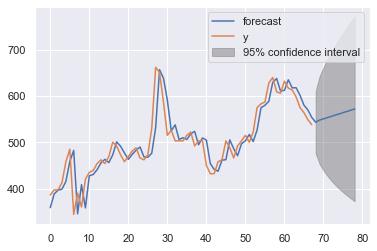

In [43]:
model = ARIMA(X, order=(0,1,2))
model_fit = model.fit()

yhat = model_fit.forecast(steps=10)[0]

model_fit.plot_predict(1,79)

plt.show()

In [45]:
yhat

array([543.33214061, 547.86527016, 550.53786156, 553.21045296,
       555.88304435, 558.55563575, 561.22822715, 563.90081854,
       566.57340994, 569.24600134])

In [47]:
model_fit.forecast()

(array([543.33214061]),
 array([34.31282951]),
 array([[476.08023056, 610.58405065]]))

In [48]:
forecast

array([541.91810148, 546.07380944, 548.68815889, 551.21025321,
       553.88863606, 556.58346351, 559.2627545 , 561.93965416,
       564.61806513, 567.29679106])

In [51]:
rmse = sqrt(mean_squared_error(validation,forecast))
rmse

38.16220807080482

### Rough